<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

# BUILDING FLOOR RECOGNITION

Inspired by https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb

# Table of Contents

>[BUILDING FLOOR RECOGNITION](#scrollTo=SsIKuyArEu5c)

>[Table of Contents](#scrollTo=4sAfyFF7dWGm)

>[setup](#scrollTo=nogA7rji8GbZ)

>[utils](#scrollTo=1o3-BVUy8-sF)

>[Data](#scrollTo=pk-sYaYF7U9Y)

>>[Fetch cleaned dataset](#scrollTo=ALAyxPryCqFZ)

>>[sample audio](#scrollTo=w9GlJyvB2SoK)

>>[Modalities experimentations](#scrollTo=t46qlhPe2vHq)

>>>[Raw](#scrollTo=9ZMbXtvfG7Sa)

>>>[Spectrogram](#scrollTo=BAQnayGxG9vz)

>>>[MFCC](#scrollTo=b5Vm59MxHBYF)

>[Preprocessing & Packaging](#scrollTo=vg4POlOg2W6W)

>>[Waveform](#scrollTo=4jVjfEH_58rV)

>>[Spectrogram](#scrollTo=sHgonxaM55bk)

>>[MFCC](#scrollTo=zgxrq6hy512E)

>>[Late fusion](#scrollTo=zHJDrkAhh522)

>>[Splitting Scheme](#scrollTo=9fs5X3NsPoZC)

>[Models](#scrollTo=PqSY1g2A2Yop)

>>[Pretrained](#scrollTo=mgXcolX4i9wc)

>>[SimpleNet](#scrollTo=2VMz6UQNvOzu)

>>[M5](#scrollTo=VBk4K9jdvRnQ)

>>[2d-CNN](#scrollTo=2bE-6QvuyNRH)

>[Training & Evaluation](#scrollTo=-b6VY1rH4Yrq)

>>[utils](#scrollTo=C47C65anl7y7)

>>[Dataset Creation](#scrollTo=yoOivocnTSUS)

>>[E2E : Training & Evaluation](#scrollTo=tJxMkoJA-Jt-)

>>[Late Fusion: Training & Evaluation](#scrollTo=i3H0iI0tshqr)

>>[Early Fusion : Training & Evaluation](#scrollTo=AgU0S5cWgpi9)

>[Results](#scrollTo=DsWDErTBXs3L)



In [1]:
# https://stats.stackexchange.com/questions/559009/why-convert-spectrogram-to-rgb-for-machine-learning

same buildings recording shall not be distributed between train and test sets


Remember:

* Train with more data
* Data Augmentation
* adding noise to the input and ouput data
* feature selection
* cross-validation
* simplify data
* regularization
* ensembling
* early stopping
* adding dropout layers


# setup

In [2]:
!nvidia-smi

Fri Jul 22 13:12:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.autograd import Variable
from torch import nn

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cu113
0.12.0+cu113


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import random 
import os
from copy import deepcopy

In [7]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
from IPython.display import Audio, display
from typing import Dict,Any

In [9]:
import librosa


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [10]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
from sklearn.metrics import classification_report

In [12]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torchaudio.utils.sox_utils.set_seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [13]:
seed_all(496)

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [15]:
from torch.utils.data import Dataset

In [16]:
from torchvision import datasets, models, transforms


In [17]:
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 29.3 MB/s 
     |████████████████████████████████| 153 kB 42.6 MB/s 
     |████████████████████████████████| 181 kB 60.0 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=de657f8dde4eb7db52185f4ab650ef4e0141828153dc12d596e292970566ce81
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [20]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [21]:
# show current directory
!pwd

/content


# utils

In [22]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)


def estimate_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  print('Approximated model size: {:.3f}MB'.format(size_all_mb))

In [23]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [24]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [25]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [26]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [27]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [28]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


# Data 

## Fetch cleaned dataset

In [30]:
# delete data if already existing
!rm -r Data/
!rm building_floor_recognition_chunked.csv

# download from remote repo
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_chunked_5.zip
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/building_floor_recognition_chunked_5.csv
!unzip -o -qqq Data_chunked_5.zip 

# delete useless artifacts
!rm Data_chunked_5.zip

--2022-07-22 13:14:00--  https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_chunked_5.zip
Resolving huggingface.co (huggingface.co)... 35.174.43.234, 54.84.221.13, 2600:1f18:147f:e800:67ee:7976:c820:7dbe, ...
Connecting to huggingface.co (huggingface.co)|35.174.43.234|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/ca507037a266b8fb66807ad3adb61a46f897612ce392c639ac04a6aab6cf572a?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked_5.zip%22 [following]
--2022-07-22 13:14:00--  https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/ca507037a266b8fb66807ad3adb61a46f897612ce392c639ac04a6aab6cf572a?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked_5.zip%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 52.85.1

In [31]:
# reading descriptor document (a .csv file describing audio samples in dataset)
raw_dataset = pd.read_csv("building_floor_recognition_chunked_5.csv")
dataset = raw_dataset.copy()
dataset.floor.replace({1:0,3:1,5:2},inplace=True)
dataset.head(10)

,samples,floor,building
0,R+3/VM09/Esquissons_VM09.wav_0.wav,1,VM09
1,R+1/HS04/Esquissons_HS04.wav_1.wav,0,HS04
2,R+3/EC11/Esquissons_EC11.wav_4.wav,1,EC11
3,R+5/FV13_B_1/Esquissons_FV13B_1.wav_2.wav,2,FV13_B
4,R+5/FV14/Esquissons_FV14 wave.wav_2.wav,2,FV14
5,R+3/EC08B_1/Esquissons_EC08B_1.wav_2.wav,1,EC08B
6,R+3/EC07A_1/Esquissons_EC07A_1.wav_3.wav,1,EC07A
7,R+5/CB02/Esquissons_CB02S01 wave.wav_4.wav,2,CB02
8,R+5/FV13_A/Esquissons_FV13A.wav_2.wav,2,FV13
9,R+1/HS04/Esquissons_HS04.wav_0.wav,0,HS04


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


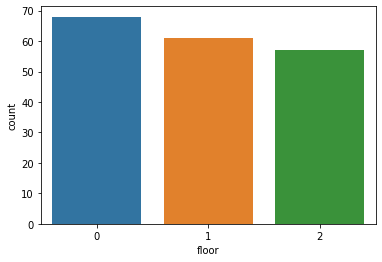

In [32]:
# number of samples per floor
sns.countplot(dataset.floor)

In [33]:
# List of buildings
buildings = dataset.building.unique()
buildings

array(['VM09', 'HS04', 'EC11', 'FV13_B', 'FV14', 'EC08B', 'EC07A', 'CB02',
       'FV13', 'CB09', 'VM02', 'EC07-B', 'HS20', 'CB05S01', 'FV12',
       'TIS06', 'CB03', 'VM06', 'CB01', 'FV11', 'VM04', 'EC10', 'VM03',
       'FV02', 'FV06', 'EC02', 'CB04', 'FV03B', 'CB06'], dtype=object)

In [34]:
# d = dataset.drop_duplicates(['building','floor']).reset_index(drop=True)[['building','floor']]

## sample audio

In [35]:
# sample wav for testing purposes
sampled = raw_dataset.sample(1)
SAMPLE_WAV_PATH=os.path.join("/content","Data",sampled.samples.values[0])
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)
print(sampled.samples.values[0])
play_audio(waveform,sample_rate)
print("Etage ",sampled.floor.values[0])

AudioMetaData(sample_rate=48000, num_frames=240000, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Sample Rate: 48000
Shape: (1, 240000)
Dtype: torch.float32
 - Max:      0.054
 - Min:     -0.059
 - Mean:     0.000
 - Std Dev:  0.009

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0186, 0.0170, 0.0161]])

R+1/CB09_2/Esquissons_CB09_2.wav_0.wav


Etage  1


In [38]:
# path=os.path.join("/content","Data","R+1","CB01_2","Esquissons_CB01_2.wav")
# waveform,sample_rate = torchaudio.load(path,format="wav")
# play_audio(waveform,sample_rate)

In [39]:
dataset

,samples,floor,building
0,R+3/VM09/Esquissons_VM09.wav_0.wav,1,VM09
1,R+1/HS04/Esquissons_HS04.wav_1.wav,0,HS04
2,R+3/EC11/Esquissons_EC11.wav_4.wav,1,EC11
3,R+5/FV13_B_1/Esquissons_FV13B_1.wav_2.wav,2,FV13_B
4,R+5/FV14/Esquissons_FV14 wave.wav_2.wav,2,FV14
...,...,...,...
181,R+5/TIS06/Esquissons_TIS06.wav_1.wav,2,TIS06
182,R+3/EC10_1/Esquissons_EC10_1.wav_2.wav,1,EC10
183,R+1/CB04_2/Esquissons_CB04_2.wav_2.wav,0,CB04
184,R+1/EC02/Esquissons_EC02.wav_4.wav,0,EC02


In [40]:
dataset.building.nunique()#==68+61+57

29

## Modalities experimentations

### Raw

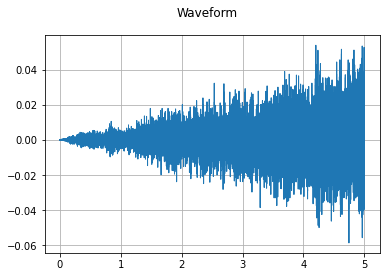

In [41]:
# plot raw waveform

plot_waveform(waveform,sample_rate=sample_rate)

In [42]:
waveform.shape

torch.Size([1, 240000])

In [43]:
random.uniform(0.85,1.15)

1.0689991808581503

In [44]:
random.choice([1.1,1.2])

1.2

In [45]:

effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", str(random.choice([0.85,0.9,0.95,1.15,1.05]))],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ['gain', '-n', str(random.choice([-10,-5,0,5,10]))],  # apply 10 db attenuation

    ["rate", f"{sample_rate}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)


In [46]:
play_audio(waveform2,sample_rate2)

### Spectrogram

Shape: (1, 513, 469)
Dtype: torch.float32
 - Max:     39.966
 - Min:      0.000
 - Mean:     0.034
 - Std Dev:  0.399

tensor([[[1.7559e-09, 1.0982e-10, 4.2962e-08,  ..., 3.0578e+00,
          1.5034e+00, 3.1367e-01],
         [4.7598e-09, 7.6090e-10, 7.3897e-08,  ..., 4.3847e+00,
          6.0061e+00, 4.3869e+00],
         [7.3814e-09, 1.6949e-12, 6.0301e-08,  ..., 7.0145e-02,
          1.3014e+00, 1.8921e+01],
         ...,
         [1.5902e-05, 4.2947e-07, 1.6832e-05,  ..., 6.7545e-06,
          3.2312e-06, 2.0906e-05],
         [8.0830e-06, 4.2977e-06, 1.9919e-06,  ..., 5.2626e-06,
          2.6408e-06, 1.5716e-05],
         [2.0610e-06, 1.3592e-05, 1.4554e-07,  ..., 8.5354e-11,
          1.2594e-05, 4.8517e-06]]])



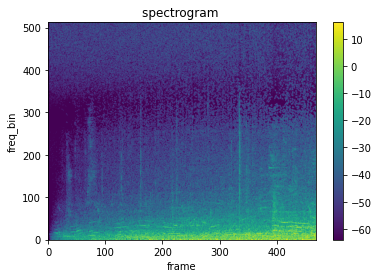

In [47]:
n_fft = 1024
win_length = 1024
hop_length = None

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=False,
)

# define transformation
spectrogram_norm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True,
)
# Perform transformation
spec1 = spectrogram(waveform)
# Perform transformation
spec2 = spectrogram_norm(waveform)


print_stats(spec1)
#print_stats(spec2)
plot_spectrogram(spec1[0], title='spectrogram ')
#plot_spectrogram(spec2[0], title='spectrogram normalized')

In [48]:
spec2[0].max()

tensor(0.1041)

In [49]:
spec1[0].max()

tensor(39.9663)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

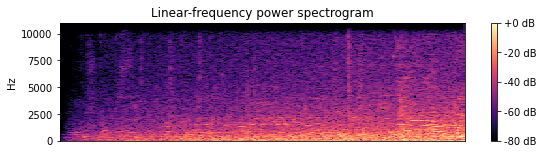

In [36]:
# obtaining spectrogram using librosa
import librosa.display

dat2, sampling_rate2 = librosa.load(os.path.join("/content/Data",sampled.samples.values[0]))
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

### MFCC

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape: (1, 256, 469)
Dtype: torch.float32
 - Max:     215.383
 - Min:     -948.948
 - Mean:    -3.555
 - Std Dev: 28.664

tensor([[[-9.4895e+02, -9.4691e+02, -9.1922e+02,  ..., -2.3718e+02,
          -2.4442e+02, -2.4761e+02],
         [-5.8115e+01, -6.0381e+01, -4.5576e+01,  ...,  2.1134e+02,
           1.9938e+02,  2.0428e+02],
         [ 5.1160e+01,  5.2512e+01,  7.4457e+01,  ..., -2.0711e+01,
          -2.0109e+01, -8.3311e+00],
         ...,
         [ 1.0837e+00,  2.5038e-01, -1.6555e+00,  ...,  5.1107e+00,
           5.0182e+00,  2.0431e+00],
         [-8.8754e-01,  3.2777e-02,  1.7779e+00,  ...,  3.1898e+00,
           3.9191e+00,  3.4012e+00],
         [ 5.0172e-01,  3.3894e-02, -1.6526e+00,  ...,  2.8279e+00,
           9.4324e-01,  3.7482e+00]]])



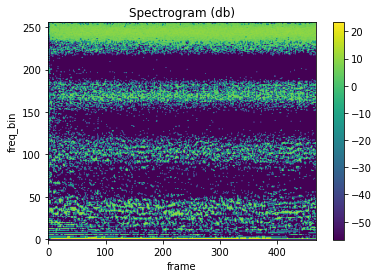

In [50]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

# Preprocessing & Packaging

check 
* https://jonathanbgn.com/2021/08/30/audio-augmentation.html
* https://developers.deepgram.com/blog/2022/06/pytorch-intro-with-torchaudio/

## Waveform

In [53]:
class SoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList,transform = False):
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        self.transform = transform
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i,1] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i,1])
                #self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
         #self.mixer = torchaudio.transforms.DownmixMono() 
        self.folderList = folderList
        
    def __getitem__(self, index):
        #format the file path and load the file
        path = self.file_path + self.file_names[index]
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
        sound ,sample_rate = torchaudio.load(path, normalize = True)
        #print(sound.shape)
        # apply some effects : https://pytorch.org/tutorials//beginner/audio_data_augmentation_tutorial.html
        # if self.transform:
        #   effects = [
        #       #["lowpass", "-1", "300"],  # apply single-pole lowpass filter
        #       ["speed", str(random.choice([0.95,1,1.05]))],  # reduce the speed
        #       # This only changes sample rate, so it is necessary to
        #       # add `rate` effect with original sample rate after this.
        #       ['gain', '-n', str(random.choice([-5,-2.5,0,2.5,5]))],  # apply 10 db attenuation

        #       ["rate", f"{sample_rate}"],
        #       #["reverb", "-w"],  # Reverbration gives some dramatic feeling
        #   ]
        #   # # Apply effects
        #   sound, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(sound, sample_rate, effects)
        #   #print(sound.shape)
        #   sound = torch.mean(sound, dim=0).unsqueeze(0) # #UrbanSound8K uses two channels, this will convert them to one
        soundData = sound
        #print(soundData.shape,soundData.numel())
        #downsample the audio to ~8kHz
        # 120000
        tempData = torch.zeros([200000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 200000:
            tempData[:soundData.numel()] = soundData[:].T
        else:
            tempData[:] = soundData[:,:200000].T
        
        soundData = tempData
        soundFormatted = torch.zeros([40000, 1])
        #chunk = random.randint(0,4)
        soundFormatted[:40000] = soundData[::5]#take every sixth sample of soundData
        #soundFormatted = soundFormatted[chunk*40000:(chunk+1)*40000] #take a random chunk
        soundFormatted = soundFormatted.permute(1, 0)

        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)


## Spectrogram

In [54]:
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# check also https://colab.research.google.com/github/enzokro/clck10/blob/master/_notebooks/2020-09-10-Normalizing-spectrograms-for-deep-learning.ipynb#scrollTo=VBD562J9i2AF
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled


def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - 1.15) / (27 + eps)
  #spec_min, spec_max = spec_norm.min(), spec_norm.max()
  #spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_norm

In [55]:
class SpecSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_fft, normalized=False, win_length = None, center = True,transform = False, pad_mode = "reflect", power = 2.0,hop_length=None):
        super().__init__(csvData, file_path, folderList,transform)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._center = center
        self._pad_mode = pad_mode
        self._power = power
        self._normalized = normalized
        # define transformation
        spectrogram = T.Spectrogram(
          n_fft= self._n_fft,
          win_length=self._win_length,
          hop_length=self._hop_length,
          center=self._center,
          pad_mode=self._pad_mode,
          power=self._power,
          normalized=self._normalized,
        )
        self._spec_mixer = spectrogram
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      transformed = self._spec_mixer(soundFormatted)
      # apply transformation
      return transformed, labels

    
    def __len__(self):
        return len(self.file_names)

## MFCC

In [56]:
# NORMALIZE VALUES
class MFCCSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_mfcc, sample_rate, n_fft = None, n_mels = None, mel_scale = 'htk',hop_length=512):
        super().__init__(csvData, file_path, folderList)
        self._n_fft = n_fft
        #print("ok",win_length)
        #self._win_length = win_length
        self._hop_length = hop_length
        self._n_mels = n_mels
        self._n_mfcc = n_mfcc 
        self._sample_rate = sample_rate
        self._mel_scale = mel_scale
        mfcc_transform = T.MFCC(
            sample_rate= self._sample_rate,
            n_mfcc=self._n_mfcc,
            
            melkwargs={
              'n_fft': self._n_fft,
              'n_mels': self._n_mels,
              'hop_length': self._hop_length,
              'mel_scale': self._mel_scale,
              #'win_length':self._n_fft,
            },
        )

        self._mfcc_transform = mfcc_transform
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._mfcc_transform(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

## Late fusion

In [57]:
# NORMALIZE VALUES
class ComposedDataset(MFCCSoundDataset,SpecSoundDataset):    
    def __init__(self, datasets):
        assert(len(datasets)>0),"You should provide at least one dataset"
        assert(len(datasets[0])>0),"Datasets must not be empty"
        assert(all(len(datasets[0])==len(d) for d in datasets)),"All datasets don't have same size"
        self.datasets = datasets

    def __getitem__(self, index):
      tmp = [dataset[index] for dataset in self.datasets]
      labels = tmp[0][1]
      return tuple([t[0] for t in tmp]),labels
    
    def __len__(self):
        return len(self.datasets[0])

## Splitting Scheme

In [58]:
os.chdir("/content/")

In [59]:
csv_path = './building_floor_recognition.csv'
file_path = './Data/'

In [60]:
# DEPRECATED
# X_train, X_test = train_test_split(dataset, test_size=0.2, stratify = dataset.floor)
# X_train, X_val = train_test_split(X_train, test_size=0.2, stratify = X_train.floor)

In [61]:
# Testing scheme assuring that no building is in train and test set

test_dataset_ = dataset.drop_duplicates(['building']).groupby('floor').apply(lambda x: x.sample(3)).reset_index(drop=True)[['building','floor']]
test_dataset = pd.merge(dataset,test_dataset_, on = ['building','floor'])
test_dataset.head()
new_dataset = pd.concat([dataset,test_dataset]).drop_duplicates(keep=False)
val_dataset_ = new_dataset.drop_duplicates(['building']).groupby('floor').apply(lambda x: x.sample(1)).reset_index(drop=True)[['building','floor']]
val_dataset = pd.merge(dataset,val_dataset_, on = ['building','floor'])
val_dataset.head()
final_dataset = pd.concat([new_dataset,val_dataset]).drop_duplicates(keep=False)
final_dataset.shape
assert(len(final_dataset)+len(val_dataset)+len(test_dataset)==len(dataset)),"You did something wrong"

In [62]:
X_train = final_dataset
X_val = val_dataset
X_test = test_dataset

In [63]:
print("All set size: " + str(len(dataset)))
print("Train set size: " + str(len(X_train)))
print("Val set size: " + str(len(X_val)))
print("Test set size: " + str(len(X_test)))


All set size: 186
Train set size: 118
Val set size: 14
Test set size: 54


In [97]:
# # configure MFCC settings 
# config_spec_args = {
#     'n_fft':512,
#     'n_mfcc':180,
#     'sample_rate':8000,
#     'n_mels':180,

# }

# train_set = MFCCSoundDataset(X_train, file_path, range(0,6), **config_spec_args)
# test_set = MFCCSoundDataset(X_test, file_path, [10], **config_spec_args)

# Models

## Pretrained

In [65]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


## SimpleNet

In [66]:
class SimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3,repr_size = 9012):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels = 128, kernel_size = 5, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size = 5, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

        
            nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(32,16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            # nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            nn.MaxPool2d(2,2),

            # nn.Conv2d(64,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),

            # nn.Conv2d(128,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(repr_size,128),
            nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            nn.Linear(128,n_output),
            # nn.Softmax(),
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


In [67]:
class NotSimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3,repr_size = 512):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

        
            nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(64,32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32,16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16,16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(repr_size,128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,n_output),
            #nn.Softmax(),
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


In [68]:
class SimpleSimpleNet(nn.Module):
    def __init__(self,in_channels=1, n_output=3,repr_size = 1984):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels = 32, kernel_size = 8, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 16, kernel_size = 8, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.6),
            nn.ReLU(),
            nn.MaxPool2d(8,8),

        
            # nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(32),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.Conv2d(32,16, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(16),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
            
            # nn.Conv2d(64, 16, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(16),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
           # nn.MaxPool2d(8,8),

            # nn.Conv2d(64,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),

            # nn.Conv2d(128,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(repr_size,64),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64,n_output),
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


## M5

In [69]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


## 2d-CNN

In [70]:
# https://www.kaggle.com/code/mhiro2/simple-2d-cnn-classifier-with-pytorch/notebook
# It is nicknamed "bigone" below

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        import torch.nn.functional as F
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [71]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=128),
            nn.Dropout(0.2),
            ConvBlock(in_channels=128, out_channels=128),
            nn.Dropout(0.2),
            ConvBlock(in_channels=128, out_channels=256),
            nn.Dropout(0.2),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            #nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

# Training & Evaluation

## utils

In [72]:
# Reporting strategies

class Reporter:
  """
    proxy used for any reporter ( wandb, tensorboard, etc)
  """
  def __init__(self):
    pass

  def log(self,data:Dict[str, Any]):
    raise NotImplementedError

  def stop(self):
    raise NotImplementedError
  def start(self,**kwargs):
    raise NotImplementedError

class WandbReporter(Reporter):
  """
    wand reporter with permanent storage and wandb dashboard
  """
  def __init__(self,wandb,**kwargs):
    super().__init__()
    self._wandb = wandb
    self._kwargs = kwargs
  
  def log(self,data:Dict[str, Any]):
    self._wandb.log(data)

  def stop(self):
    self._wandb.finish()

  def start(self,**kwargs):
    self._wandb.init(project="audio-classification",**self._kwargs)
    


class DummyReporter(Reporter):
  """
    quick reporter with non permanent storage
  """
  def __init__(self):
    self._data={}

  def log(self,data:Dict[str, Any]):
    for key in data.keys():
      if key in self._data:
        self._data[key].append(data[key])
      else:
        self._data[key]=[data[key]]

  def get(self,key):
    return self._data[key]

  def stop(self):
    pass

  def start(self,**kwargs):
    pass

In [73]:
# Function to save the model
def saveModel(model,loss,base_path,suffix):
    path = f"bestModel_{suffix}.pth"
    if base_path:
      path = os.path.join(base_path,path)

    torch.save(model.state_dict(), path)

    return path

In [74]:
# Function to test the model with the test dataset and print the accuracy for the test images
def evaluate(model,test_loader,loss_fn,device=torch.device("cpu")):
    model.eval()
    model.to(device)
    accuracy = 0.0
    total = 0.0
    correct_true = 0.0
    predicted_true = 0.0
    target_true = 0.0
    loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
          
            #print(outputs.data)
            loss += loss_fn(outputs, labels) * labels.size(0)
            
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            # print(predicted)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
    accuracy = (100 * accuracy / total)
    return (loss.item()/len(test_loader.sampler), accuracy)

In [75]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model,train_loader,optimizer,loss_fn,train_steps=1000,device=torch.device("cpu"),reporter = None):
    
    best_accuracy = 0.0
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    
    
    running_loss = 0.0
    running_acc = 0.0
    running_samples = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        
        model.train()
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))


        # predict classes using images from the training set
        outputs = model(images)
        # print(outputs.data)
        # print("labels=",labels)
        # compute the loss based on model output and real labels
        loss = loss_fn(outputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        #loss = F.nll_loss(outputs.squeeze(), labels)
        
        # backpropagate the loss
        loss.backward()

        # # https://discuss.pytorch.org/t/how-to-check-for-vanishing-exploding-gradients/9019
        # for name, param in model.named_parameters():
        #  print(name, param.grad.norm())
        #adjust parameters based on the calculated gradients
        optimizer.step()

        # Let's print statistics for every 1,000 images
        running_loss += loss.item() * labels.size(0)    # extract the loss value
        running_samples += labels.size(0)
        # print(running_samples)
      #if i % (train_steps) == (train_steps-1):    
      # print every 1000 (twice per epoch) 
        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / running_samples))
        if reporter:
            reporter.log({'train_loss':running_loss / running_samples})
          # zero the loss
        #return running_loss

        

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_classification_stats(model,loader,device):
  y_pred = []
  y_true = []

  model.eval()
  model.to(device)
  # iterate over test data
  for inputs, labels in loader:
          inputs,labels = inputs.to(device),labels.to(device)
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('R+1', 'R+3', 'R+5')

  # Build confusion matrix
  #cf_matrix = confusion_matrix(y_true, y_pred)
  #df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
  #                    columns = [i for i in classes])
  #plt.figure(figsize = (12,7))
  #sn.heatmap(df_cm, annot=True)
  #plt.savefig('output.png')
  print(classification_report(y_true, y_pred, target_names=classes))
  #plt.title()
  #plt.plot()


In [77]:
def initialize_weights(m):
   # look at : https://androidkt.com/initialize-weight-bias-pytorch/
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [78]:
# # define a cross validation function
# def crossvalid(model=None,criterion=None,dataset=None,k_fold=5,device=torch.device("cpu"),num_epochs=1, train_steps=1,lr=3e-4):
    
#     train_score = pd.Series()
#     val_score = pd.Series()
    
#     total_size = len(dataset)
#     fraction = 1/k_fold
#     seg = int(total_size * fraction)
#     # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
#     # index: [trll,trlr],[vall,valr],[trrl,trrr]
#     for i in range(k_fold):
#         print(f"Fold {i+1} training")
#         trll = 0
#         trlr = i * seg
#         vall = trlr
#         valr = i * seg + seg
#         trrl = valr
#         trrr = total_size
        

#         print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
#                 % (trll,trlr,trrl,trrr,vall,valr))
 
#         train_left_indices = list(range(trll,trlr))
#         train_right_indices = list(range(trrl,trrr))
        
#         train_indices = train_left_indices + train_right_indices
#         val_indices = list(range(vall,valr))
        
#         train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
#         val_set = torch.utils.data.dataset.Subset(dataset,val_indices)


#         _train_loader = torch.utils.data.DataLoader(train_set, batch_size=5,shuffle=True)
#         _val_loader = torch.utils.data.DataLoader(val_set, batch_size=5,shuffle=True)
        
#         res_model = deepcopy(model)
#         _optimizer = torch.optim.Adam(res_model.parameters(), lr=lr)
#         train_acc = train(res_model,_train_loader,_optimizer,criterion,eval_loader=_val_loader,num_epochs = num_epochs, train_steps=train_steps,device=device)
#         train_score.at[i] = train_acc
#         val_acc = valid(res_model,_val_loader,criterion,device)
#         val_score.at[i] = val_acc
#         del res_model
    
#     return train_score,val_score

In [79]:
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

check out https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc

## Dataset Creation

In [80]:
DATA ={}

In [98]:

train_spectrogram = True
batch_size = 16
if train_spectrogram:
  # configure spectrogram settings 
  config_spec_args = {
      'n_fft':1024,
      'win_length':1024,
  }
  all_set = SpecSoundDataset(dataset, file_path, range(0,6),**config_spec_args)
  train_set = SpecSoundDataset(X_train, file_path, range(0,6),transform = False, **config_spec_args)
  val_set = SpecSoundDataset(X_val, file_path, range(0,6), **config_spec_args)
  test_set = SpecSoundDataset(X_test, file_path, range(0,6), **config_spec_args)
  n_classes = X_train.floor.nunique()
  print("All set size: " + str(len(all_set)))
  print("Train set size: " + str(len(train_set)))
  print("Val set size: " + str(len(val_set)))
  print("Test set size: " + str(len(test_set)))



  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
  train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = True, **kwargs)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, **kwargs)
  DATA['spec']={}
  DATA['spec']['train_set']=train_set
  DATA['spec']['test_set']=test_set
  DATA['spec']['train_loader']=train_loader
  DATA['spec']['val_loader']=val_loader
  DATA['spec']['test_loader']=test_loader


All set size: 186
Train set size: 118
Val set size: 14
Test set size: 54


In [99]:
batch_size = 16
if train_spectrogram:
  # configure spectrogram settings 
  config_spec_args = {
      'n_fft':1024,
      'win_length':1024,
      'normalized':True,
  }
  all_set = SpecSoundDataset(dataset, file_path, range(0,6),**config_spec_args)
  train_set = SpecSoundDataset(X_train, file_path, range(0,6),transform = False, **config_spec_args)
  val_set = SpecSoundDataset(X_val, file_path, range(0,6), **config_spec_args)
  test_set = SpecSoundDataset(X_test, file_path, range(0,6), **config_spec_args)
  n_classes = X_train.floor.nunique()
  print("All set size: " + str(len(all_set)))
  print("Train set size: " + str(len(train_set)))
  print("Val set size: " + str(len(val_set)))
  print("Test set size: " + str(len(test_set)))



  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
  train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = True, **kwargs)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, **kwargs)
  DATA['spec_norm']={}
  DATA['spec_norm']['test_set']=test_set
  DATA['spec_norm']['train_loader']=train_loader
  DATA['spec_norm']['val_loader']=val_loader
  DATA['spec_norm']['test_loader']=test_loader


All set size: 186
Train set size: 118
Val set size: 14
Test set size: 54


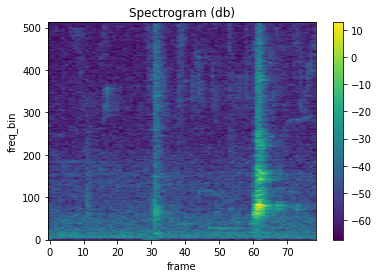

In [100]:
a = plot_spectrogram(val_set[8][0][0]) # first index 

In [101]:
train_mfcc = True
batch_size = 16
if train_mfcc:
  # configure spectrogram settings 
  config_mel_args={
                'n_fft':512,
              'n_mfcc': 1024,
              'n_mels': 1024,
              'sample_rate':8820,
              #'hop_length':512,
  }
  all_set = MFCCSoundDataset(dataset, file_path, range(0,6),**config_mel_args)
  train_set = MFCCSoundDataset(X_train, file_path, range(0,6), **config_mel_args)
  val_set = MFCCSoundDataset(X_val, file_path, range(0,6), **config_mel_args)
  test_set = MFCCSoundDataset(X_test, file_path, range(0,6), **config_mel_args)
  n_classes = X_train.floor.nunique()
  print("All set size: " + str(len(all_set)))
  print("Train set size: " + str(len(train_set)))
  print("Val set size: " + str(len(val_set)))
  print("Test set size: " + str(len(test_set)))



  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
  train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = True, **kwargs)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, **kwargs)
  DATA['mfcc']={}
  DATA['mfcc']['test_set']=test_set
  DATA['mfcc']['train_set']=train_set
  DATA['mfcc']['train_loader']=train_loader
  DATA['mfcc']['val_loader']=val_loader
  DATA['mfcc']['test_loader']=test_loader


All set size: 186
Train set size: 118
Val set size: 14
Test set size: 54


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1024) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


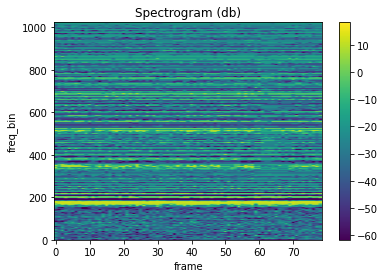

In [102]:
a = plot_spectrogram(val_set[8][0][0]) # first index 

In [103]:
val_set[8][0][0].shape

torch.Size([1024, 79])

## E2E : Training & Evaluation

In [104]:
!set CUDA_LAUNCH_BLOCKING=1
os.chdir("/content/")

In [105]:
MODELS = {
    'simplesimplenet':SimpleSimpleNet(in_channels=1,n_output=n_classes,repr_size=1984),
    'simplenet':SimpleNet(in_channels=1,n_output=n_classes,repr_size=9072),
    'notsimplenet':NotSimpleNet(in_channels=1,n_output=n_classes,repr_size=512),
    'simplesimplenetmfcc':SimpleSimpleNet(in_channels=1,n_output=n_classes,repr_size=4032),
    'simplenetmfcc':SimpleNet(in_channels=1,n_output=n_classes,repr_size=18288),
    'notsimplenetmfcc':NotSimpleNet(in_channels=1,n_output=n_classes,repr_size=1024),
    "bigone":Classifier(3),
}

In [106]:
test_model = NotSimpleNet(in_channels=1,n_output=n_classes,repr_size=512)
test_model(next(iter(DATA['spec_norm']['test_loader']))[0][0].unsqueeze(0))

tensor([[-0.0333, -0.0674, -0.1269]], grad_fn=<AddmmBackward0>)

In [107]:
next(iter(DATA['spec']['train_loader']))[0][0].unsqueeze(0).shape

torch.Size([1, 1, 513, 79])

In [108]:
MODELS_MODALITY ={
    "spec":{
        'bigone',
        'simplenet',
        'notsimplenet',
        'simplesimplenet',
    },
    "spec_norm":{
        'bigone',
        'simplenet',
        'notsimplenet',
        'simplesimplenet',
    },
    "mfcc":
    {
        'simplenetmfcc',
        'notsimplenetmfcc',
        'simplesimplenetmfcc'
    }
}

save_path = "/content/drive/MyDrive/consistency/audio-classification"

In [109]:
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [110]:
for modality in {'spec','spec_norm','mfcc'}:
  for model_name in MODELS_MODALITY[modality]:
    print(f"{bcolors.OKBLUE}Evaluating {model_name} on modality {modality}{bcolors.ENDC}")
    model = MODELS[model_name]
    if hasattr(model, '_init_weights'):
      model._init_weights()
    else:
      model.apply(initialize_weights) # Initilialize model weights
    rate_learning = 3e-4 #karapthy constant
    optimizer = torch.optim.Adam(model.parameters(), lr=rate_learning)
    loss_fn = nn.CrossEntropyLoss()
    patience = 3
    reduce_plateau_factor = 0.5
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience = patience, factor=reduce_plateau_factor, verbose=True)
    num_epochs = 40
    early_stop = 100
    chunk_size = 5
    reporter = WandbReporter(wandb,name=f"{model_name}-{modality}", config={"model":model_name, "epochs":num_epochs, "learning_rate":rate_learning, "batch_size":batch_size, "reduce_plateau_factor":0.5, "reduce_on_plateau_patience":batch_size, "chunked":chunk_size})
    
    # Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
  
    best_accuracy = 0.0
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    best_loss = 1e7
    count = 0

    if reporter:
      reporter.start()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        
        running_loss = train(model,DATA[modality]['train_loader'],optimizer,loss_fn,train_steps=1,device=device,reporter=reporter)
        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        train_loss, train_accuracy = evaluate(model,DATA[modality]['train_loader'],loss_fn,device)
        eval_loss, accuracy = evaluate(model,DATA[modality]['val_loader'],loss_fn,device)
        print('Epoch[', epoch+1,'] eval accuracy %d %%' % (accuracy),"eval loss %.3f" % (eval_loss))
        if reporter:
          reporter.log({'eval_loss':eval_loss,'eval_accuracy':accuracy})
          reporter.log({'train_loss_epoch':train_loss,'train_accuracy':train_accuracy})
        
        # we want to save the model if the accuracy is the best
        if best_loss > eval_loss:
            print("Saving best model so far model eval loss = ",eval_loss)
            saved_path = saveModel(model, eval_loss, base_path = save_path, suffix = f'{model_name}_{modality}')
            #model.save(os.path.join(wandb.run.dir, f"model_{model_name}_{modality}.h5"))
            best_loss = eval_loss
            count = 0 
        else:
          count += 1
        scheduler.step(eval_loss)
        
        if count>early_stop:
          print("Early Stopping loss did not improve for ",early_stop," epochs")
          break
    if reporter:
      reporter.stop()
      
    loaded_model = MODELS[model_name]
    loaded_model.load_state_dict(torch.load(saved_path))
    eval_train = evaluate(loaded_model,DATA[modality]['train_loader'],loss_fn,device)
    eval_eval = evaluate(loaded_model,DATA[modality]['val_loader'],loss_fn,device)
    eval_test = evaluate(loaded_model,DATA[modality]['test_loader'],loss_fn,device)
    print(f"{bcolors.OKGREEN}>> Results for {model_name} on modality {modality}{bcolors.ENDC}")
    print("Train :",eval_train,"Dev:",eval_eval,"Test",eval_test,end="\n\n",sep="\n")
    plot_classification_stats(loaded_model,DATA[modality]['test_loader'],device)

Evaluating notsimplenet on modality spec_norm


eval_accuracy,▁█▅██▃▃▆▃▃▃▆▆▃▂▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆
eval_loss,█▁▆▁▂▃▂▂▂▃▃▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_accuracy,▂▁▆▃▃▅▅▅▆▆▇▆▆▇████▇▇█████▇▇▇█▇▇▇
train_loss,██▆▄▄▄▂▂▂▂▂▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▄█▂▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,78.57143
eval_loss,0.44454
train_accuracy,58.47458
train_loss,0.43891
train_loss_epoch,0.79057


[1,     1] loss: 1.063
[1,     2] loss: 1.009
[1,     3] loss: 1.287
[1,     4] loss: 1.196
[1,     5] loss: 1.119
[1,     6] loss: 1.113
[1,     7] loss: 1.103
[1,     8] loss: 1.096
Epoch[ 1 ] eval accuracy 64 % eval loss 0.896
Saving best model so far model eval loss =  0.8959928240094867
[2,     1] loss: 0.953
[2,     2] loss: 0.875
[2,     3] loss: 0.877
[2,     4] loss: 0.875
[2,     5] loss: 0.867
[2,     6] loss: 0.883
[2,     7] loss: 0.912
[2,     8] loss: 0.919
Epoch[ 2 ] eval accuracy 64 % eval loss 1.010
[3,     1] loss: 0.842
[3,     2] loss: 0.797
[3,     3] loss: 0.836
[3,     4] loss: 0.878
[3,     5] loss: 0.879
[3,     6] loss: 0.889
[3,     7] loss: 0.887
[3,     8] loss: 0.867
Epoch[ 3 ] eval accuracy 64 % eval loss 0.974
[4,     1] loss: 0.755
[4,     2] loss: 0.789
[4,     3] loss: 0.791
[4,     4] loss: 0.818
[4,     5] loss: 0.877
[4,     6] loss: 0.887
[4,     7] loss: 0.907
[4,     8] loss: 0.901
Epoch[ 4 ] eval accuracy 71 % eval loss 1.472
[5,     1] loss: 

eval_accuracy,▄▄▄▅▂▄▁▂▄▄▂▄▂▂▇▅▅▇▇▇▇██████▇▇█▇██▇██████
eval_loss,▁▁▁▃▅██▆▅▄▄▄▄▄▄▅▅▅▄▅▅▅▅▆▅▅▅▅▆▆▅▅▆▆▇▆▅▅▅▆
train_accuracy,▁▁▁▁▁▁▃▄▄▅▆▇▆▇▆▆▆▆▆▆▇▇▆▆▇▇▆█████▇█▇▆▇█▆▆
train_loss,█▄▄▄▄▄▄▄▃▃▂▃▂▂▂▂▂▁▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▂▂
train_loss_epoch,█▇▇▆▆▆▅▄▄▄▃▃▃▂▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▂▁▁▂▂
eval_accuracy,85.71429
eval_loss,2.19878
train_accuracy,66.10169
train_loss,0.62956
train_loss_epoch,0.78973


>> Results for notsimplenet on modality spec_norm
Train :
(1.0528557987536413, 51.69491525423729)
Dev:
(0.8959926877702985, 64.28571428571429)
Test
(1.086151123046875, 42.592592592592595)

              precision    recall  f1-score   support

         R+1       0.53      0.53      0.53        19
         R+3       0.37      0.62      0.46        21
         R+5       0.00      0.00      0.00        14

    accuracy                           0.43        54
   macro avg       0.30      0.38      0.33        54
weighted avg       0.33      0.43      0.37        54

Evaluating bigone on modality spec_norm


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1,     1] loss: 1.521
[1,     2] loss: 1.249
[1,     3] loss: 1.119
[1,     4] loss: 1.276
[1,     5] loss: 1.249
[1,     6] loss: 1.215
[1,     7] loss: 1.181
[1,     8] loss: 1.157
Epoch[ 1 ] eval accuracy 50 % eval loss 0.765
Saving best model so far model eval loss =  0.7651831763131278
[2,     1] loss: 1.059
[2,     2] loss: 0.922
[2,     3] loss: 0.902
[2,     4] loss: 0.959
[2,     5] loss: 0.969
[2,     6] loss: 0.966
[2,     7] loss: 0.948
[2,     8] loss: 0.960
Epoch[ 2 ] eval accuracy 50 % eval loss 0.746
Saving best model so far model eval loss =  0.7456460680280413
[3,     1] loss: 1.052
[3,     2] loss: 1.037
[3,     3] loss: 1.006
[3,     4] loss: 0.976
[3,     5] loss: 0.984
[3,     6] loss: 0.978
[3,     7] loss: 1.007
[3,     8] loss: 1.031
Epoch[ 3 ] eval accuracy 28 % eval loss 1.424
[4,     1] loss: 1.053
[4,     2] loss: 0.973
[4,     3] loss: 0.967
[4,     4] loss: 0.968
[4,     5] loss: 0.982
[4,     6] loss: 1.059
[4,     7] loss: 1.036
[4,     8] loss: 1.034


eval_accuracy,▄▄▁▁█▆▆▄▇▅▂▁▃▃▄▅▆█▅▄▄▄▄▄▆▄▆▄▄▄▄▄▄▄▄▄▄▄▄▄
eval_loss,▂▁▄▄▂▇█▄▁▃▇▆▃▄▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂
train_accuracy,▂▁▁▁▂▃▃▇█▇▆▅▇▆▆▇▆▆▇▇████▇▇▇▇▇▇▇▇▇█▇█▇▇██
train_loss,█▅▅▅▆▄▃▄▄▅▄▃▃▃▃▁▄▂▂▃▃▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▃▂▂▂
train_loss_epoch,▇██▇▆▆▆▃▂▂▅▆▃▃▃▂▃▃▃▂▂▁▁▁▂▂▂▁▁▂▂▁▁▂▂▂▂▂▂▁
eval_accuracy,50.0
eval_loss,0.92427
train_accuracy,67.79661
train_loss,0.5813
train_loss_epoch,0.77616


>> Results for bigone on modality spec_norm
Train :
(0.7944960513357389, 67.79661016949153)
Dev:
(0.5864218303135463, 71.42857142857143)
Test
(1.7878093013057001, 46.2962962962963)

              precision    recall  f1-score   support

         R+1       0.47      0.47      0.47        19
         R+3       0.56      0.24      0.33        21
         R+5       0.42      0.79      0.55        14

    accuracy                           0.46        54
   macro avg       0.48      0.50      0.45        54
weighted avg       0.49      0.46      0.44        54

Evaluating simplenet on modality spec_norm


[1,     1] loss: 1.037
[1,     2] loss: 1.022
[1,     3] loss: 0.961
[1,     4] loss: 0.922
[1,     5] loss: 0.934
[1,     6] loss: 1.023
[1,     7] loss: 1.279
[1,     8] loss: 1.247
Epoch[ 1 ] eval accuracy 57 % eval loss 1.042
Saving best model so far model eval loss =  1.042381967817034
[2,     1] loss: 0.604
[2,     2] loss: 0.869
[2,     3] loss: 0.890
[2,     4] loss: 1.006
[2,     5] loss: 0.967
[2,     6] loss: 1.055
[2,     7] loss: 0.986
[2,     8] loss: 0.976
Epoch[ 2 ] eval accuracy 50 % eval loss 1.210
[3,     1] loss: 0.738
[3,     2] loss: 0.829
[3,     3] loss: 0.912
[3,     4] loss: 0.860
[3,     5] loss: 0.872
[3,     6] loss: 0.837
[3,     7] loss: 0.826
[3,     8] loss: 0.847
Epoch[ 3 ] eval accuracy 50 % eval loss 0.852
Saving best model so far model eval loss =  0.8524169240679059
[4,     1] loss: 0.745
[4,     2] loss: 0.700
[4,     3] loss: 0.728
[4,     4] loss: 0.693
[4,     5] loss: 0.708
[4,     6] loss: 0.717
[4,     7] loss: 0.730
[4,     8] loss: 0.700
E

eval_accuracy,▂▁▁██▇█▆▆▅▇▇▆▇▇▆▃▅▇▇▂▇▇▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
eval_loss,▅▇▄▄▃▃▅▄▄▃▆█▁▁▄▁▁▄▄▃▃▄▂▁▁▂▄▄▄▄▆▆▇▇██▇█▇█
train_accuracy,▁▂▃▁▃▄▄▅▆▆▅▅▆▆▅▇█▇▆▇▇█▇█▇▆▆█▇▇█▄▇▇▇▇▅▇▆▆
train_loss,▇█▇▅▇▅▄▄▄▃▄▃▄▃▃▃▂▂▃▂▁▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▁▂
train_loss_epoch,██▆▇▇▅▆▄▄▃▄▄▃▂▄▂▂▁▂▂▃▁▁▂▃▃▄▃▄▃▂▅▂▃▂▂▃▂▃▃
eval_accuracy,57.14286
eval_loss,1.33018
train_accuracy,59.32203
train_loss,0.2459
train_loss_epoch,0.76157


>> Results for simplenet on modality spec_norm
Train :
(0.7405261670128774, 61.86440677966102)
Dev:
(0.44646215438842773, 85.71428571428571)
Test
(1.567895394784433, 48.148148148148145)

              precision    recall  f1-score   support

         R+1       0.64      0.37      0.47        19
         R+3       0.47      0.43      0.45        21
         R+5       0.42      0.71      0.53        14

    accuracy                           0.48        54
   macro avg       0.51      0.50      0.48        54
weighted avg       0.52      0.48      0.48        54

Evaluating simplesimplenet on modality spec_norm


[1,     1] loss: 5.498
[1,     2] loss: 5.421
[1,     3] loss: 4.415
[1,     4] loss: 3.696
[1,     5] loss: 3.182
[1,     6] loss: 2.855
[1,     7] loss: 2.613
[1,     8] loss: 2.527
Epoch[ 1 ] eval accuracy 14 % eval loss 1.134
Saving best model so far model eval loss =  1.1337189674377441
[2,     1] loss: 1.600
[2,     2] loss: 1.767
[2,     3] loss: 1.435
[2,     4] loss: 1.422
[2,     5] loss: 1.347
[2,     6] loss: 1.338
[2,     7] loss: 1.273
[2,     8] loss: 1.307
Epoch[ 2 ] eval accuracy 57 % eval loss 0.970
Saving best model so far model eval loss =  0.9695800372532436
[3,     1] loss: 0.938
[3,     2] loss: 0.886
[3,     3] loss: 0.929
[3,     4] loss: 0.905
[3,     5] loss: 0.875
[3,     6] loss: 0.875
[3,     7] loss: 0.866
[3,     8] loss: 0.870
Epoch[ 3 ] eval accuracy 57 % eval loss 1.214
[4,     1] loss: 0.704
[4,     2] loss: 0.799
[4,     3] loss: 0.860
[4,     4] loss: 0.830
[4,     5] loss: 0.840
[4,     6] loss: 0.850
[4,     7] loss: 0.850
[4,     8] loss: 0.847


eval_accuracy,▁▅▅▅▆▇▆▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
eval_loss,▃▂▃▄▅▅▆▃▂▂▁▁▁▂▄▄▅▅▇██▇█▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇
train_accuracy,▁▅▃▄▃▃▅▅▆▇▇▇▆▆▆█▇▇▇███████▇▇▇▇▇▇▇██▇▇▇▇▇
train_loss,█▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇█▇▆▆▅▄▄▃▃▃▅▆▄▃▂▂▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂
eval_accuracy,78.57143
eval_loss,1.86432
train_accuracy,57.62712
train_loss,0.67087
train_loss_epoch,0.89343


>> Results for simplesimplenet on modality spec_norm
Train :
(0.9181692479020458, 56.779661016949156)
Dev:
(0.7823128019060407, 85.71428571428571)
Test
(1.1762592880814164, 51.851851851851855)

              precision    recall  f1-score   support

         R+1       0.64      0.47      0.55        19
         R+3       0.47      0.38      0.42        21
         R+5       0.48      0.79      0.59        14

    accuracy                           0.52        54
   macro avg       0.53      0.55      0.52        54
weighted avg       0.53      0.52      0.51        54

Evaluating notsimplenetmfcc on modality mfcc


[1,     1] loss: 1.536
[1,     2] loss: 1.695
[1,     3] loss: 1.455
[1,     4] loss: 1.353
[1,     5] loss: 1.350
[1,     6] loss: 1.312
[1,     7] loss: 1.302
[1,     8] loss: 1.287
Epoch[ 1 ] eval accuracy 35 % eval loss 0.972
Saving best model so far model eval loss =  0.9722396305629185
[2,     1] loss: 1.014
[2,     2] loss: 1.160
[2,     3] loss: 1.140
[2,     4] loss: 1.112
[2,     5] loss: 1.085
[2,     6] loss: 1.100
[2,     7] loss: 1.148
[2,     8] loss: 1.128
Epoch[ 2 ] eval accuracy 50 % eval loss 1.005
[3,     1] loss: 0.843
[3,     2] loss: 0.918
[3,     3] loss: 0.942
[3,     4] loss: 0.933
[3,     5] loss: 0.909
[3,     6] loss: 0.934
[3,     7] loss: 0.953
[3,     8] loss: 0.961
Epoch[ 3 ] eval accuracy 71 % eval loss 0.894
Saving best model so far model eval loss =  0.8940367698669434
[4,     1] loss: 0.989
[4,     2] loss: 0.940
[4,     3] loss: 0.912
[4,     4] loss: 0.924
[4,     5] loss: 0.905
[4,     6] loss: 0.888
[4,     7] loss: 0.909
[4,     8] loss: 0.928


eval_accuracy,▃▅█▇▃▃▃▃▃▃▃▃▄▃▂▂▂▂▁▁▁▁▃▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
eval_loss,▂▂▁▁▅▃▇▅▆█▇▇▇▇▇█▇▇▇▇██▇███▇█████▇██▇████
train_accuracy,▁▃▁▄▄▅▅▅▆▅▆▆▇▇▇▇▇█▇█████████████████████
train_loss,█▆▅▅▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▆▇▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,21.42857
eval_loss,1.45502
train_accuracy,98.30508
train_loss,0.29954
train_loss_epoch,0.27506


>> Results for notsimplenetmfcc on modality mfcc
Train :
(1.171935517909163, 32.20338983050848)
Dev:
(0.8940367698669434, 71.42857142857143)
Test
(1.2933471114547164, 37.03703703703704)

              precision    recall  f1-score   support

         R+1       0.00      0.00      0.00        19
         R+3       0.38      0.95      0.54        21
         R+5       0.00      0.00      0.00        14

    accuracy                           0.37        54
   macro avg       0.13      0.32      0.18        54
weighted avg       0.15      0.37      0.21        54

Evaluating simplesimplenetmfcc on modality mfcc


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1,     1] loss: 2.438
[1,     2] loss: 3.988
[1,     3] loss: 3.998
[1,     4] loss: 4.129
[1,     5] loss: 4.058
[1,     6] loss: 3.843
[1,     7] loss: 3.481
[1,     8] loss: 3.375
Epoch[ 1 ] eval accuracy 35 % eval loss 1.588
Saving best model so far model eval loss =  1.5880813598632812
[2,     1] loss: 3.270
[2,     2] loss: 3.821
[2,     3] loss: 3.156
[2,     4] loss: 2.600
[2,     5] loss: 2.376
[2,     6] loss: 2.325
[2,     7] loss: 2.171
[2,     8] loss: 2.110
Epoch[ 2 ] eval accuracy 28 % eval loss 1.047
Saving best model so far model eval loss =  1.0466196877615792
[3,     1] loss: 1.308
[3,     2] loss: 1.453
[3,     3] loss: 1.336
[3,     4] loss: 1.222
[3,     5] loss: 1.245
[3,     6] loss: 1.306
[3,     7] loss: 1.325
[3,     8] loss: 1.340
Epoch[ 3 ] eval accuracy 71 % eval loss 0.908
Saving best model so far model eval loss =  0.9082404545375279
[4,     1] loss: 1.093
[4,     2] loss: 0.995
[4,     3] loss: 0.971
[4,     4] loss: 1.031
[4,     5] loss: 1.139
[4,   

eval_accuracy,▂▁█▂▂▂▂▂▂▆▃▃▆▂▆▆▃▃▆▃▃▃▃▃▃▆▆▆▃▃▃▃▃▃▃▃▃▃▃▃
eval_loss,█▂▁▂▁▁▁▂▂▁▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_accuracy,▁▂▃▅▅▅▆▆▆▇▇▇▇█▇▇▇██▇█▇█▇▇███████████▇███
train_loss,█▅▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,42.85714
eval_loss,0.97439
train_accuracy,73.72881
train_loss,0.73128
train_loss_epoch,0.87261


>> Results for simplesimplenetmfcc on modality mfcc
Train :
(1.0488267025705111, 38.13559322033898)
Dev:
(0.9082404545375279, 71.42857142857143)
Test
(1.1234161942093461, 35.18518518518518)

              precision    recall  f1-score   support

         R+1       0.25      0.05      0.09        19
         R+3       0.36      0.86      0.51        21
         R+5       0.00      0.00      0.00        14

    accuracy                           0.35        54
   macro avg       0.20      0.30      0.20        54
weighted avg       0.23      0.35      0.23        54

Evaluating simplenetmfcc on modality mfcc


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1,     1] loss: 1.352
[1,     2] loss: 6.743
[1,     3] loss: 7.244
[1,     4] loss: 8.348
[1,     5] loss: 8.257
[1,     6] loss: 7.059
[1,     7] loss: 6.321
[1,     8] loss: 6.244
Epoch[ 1 ] eval accuracy 14 % eval loss 3.013
Saving best model so far model eval loss =  3.0127062116350447
[2,     1] loss: 3.952
[2,     2] loss: 3.571
[2,     3] loss: 3.376
[2,     4] loss: 3.083
[2,     5] loss: 2.863
[2,     6] loss: 2.784
[2,     7] loss: 2.493
[2,     8] loss: 2.443
Epoch[ 2 ] eval accuracy 28 % eval loss 1.232
Saving best model so far model eval loss =  1.232107707432338
[3,     1] loss: 1.052
[3,     2] loss: 1.280
[3,     3] loss: 1.437
[3,     4] loss: 1.370
[3,     5] loss: 1.441
[3,     6] loss: 1.383
[3,     7] loss: 1.434
[3,     8] loss: 1.408
Epoch[ 3 ] eval accuracy 64 % eval loss 1.124
Saving best model so far model eval loss =  1.1244795663016183
[4,     1] loss: 1.241
[4,     2] loss: 1.145
[4,     3] loss: 1.094
[4,     4] loss: 1.041
[4,     5] loss: 1.091
[4,    

eval_accuracy,▁▃▇▇▆▄▇▄▇▄▄▄▄█▄▇▅▆▅▇█▆▄▇▇▆▆█▆▇▇▇█▇▇▆▇▇▇▇
eval_loss,█▂▂▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_accuracy,▂▁▂▄▂▄▆▅▄▄▄▅▄▅▄▇▇▇▇▆▇▇▇████▇▇█▇▇██████▇▇
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,64.28571
eval_loss,1.11827
train_accuracy,71.18644
train_loss,0.75243
train_loss_epoch,0.83959


>> Results for simplenetmfcc on modality mfcc
Train :
(0.937474460925086, 52.54237288135593)
Dev:
(0.928614888872419, 64.28571428571429)
Test
(1.1087976385045935, 38.888888888888886)

              precision    recall  f1-score   support

         R+1       0.35      0.58      0.44        19
         R+3       0.45      0.43      0.44        21
         R+5       0.33      0.07      0.12        14

    accuracy                           0.39        54
   macro avg       0.38      0.36      0.33        54
weighted avg       0.39      0.39      0.36        54

Evaluating notsimplenet on modality spec


[1,     1] loss: 0.915
[1,     2] loss: 0.973
[1,     3] loss: 0.997
[1,     4] loss: 0.985
[1,     5] loss: 0.980
[1,     6] loss: 0.962
[1,     7] loss: 1.097
[1,     8] loss: 1.081
Epoch[ 1 ] eval accuracy 21 % eval loss 1.480
Saving best model so far model eval loss =  1.4797368730817522
[2,     1] loss: 0.803
[2,     2] loss: 0.834
[2,     3] loss: 1.060
[2,     4] loss: 1.006
[2,     5] loss: 1.021
[2,     6] loss: 0.989
[2,     7] loss: 0.981
[2,     8] loss: 0.961
Epoch[ 2 ] eval accuracy 21 % eval loss 1.748
[3,     1] loss: 0.864
[3,     2] loss: 0.847
[3,     3] loss: 0.865
[3,     4] loss: 0.882
[3,     5] loss: 0.890
[3,     6] loss: 0.869
[3,     7] loss: 0.856
[3,     8] loss: 0.873
Epoch[ 3 ] eval accuracy 21 % eval loss 3.016
[4,     1] loss: 0.986
[4,     2] loss: 0.849
[4,     3] loss: 0.867
[4,     4] loss: 0.832
[4,     5] loss: 0.825
[4,     6] loss: 0.823
[4,     7] loss: 0.834
[4,     8] loss: 0.837
Epoch[ 4 ] eval accuracy 28 % eval loss 3.742
[5,     1] loss: 

eval_accuracy,▁▁▁▂▂▅▃█▇▆▆▆▆███▇█▇▆▇▇▇▆▆▇▆▆▇▇█▇█▇▆▇▇▇▇▇
eval_loss,▁▁▃▄▄▅▄▅▆▆▆▆▇▄▅▆▇▆▇▇▅▅▆▇▇▇█▇▇▇▆▇▇▇█▆▇▇██
train_accuracy,▁▁▂▃▂▅▃▆▅▅▅▅▆▁▄▆▇▆▇█▅▅▆▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆
train_loss,██▆▅▆▄▄▄▄▄▂▃▄▁▂▂▂▂▃▃▂▂▃▂▁▂▁▂▁▃▂▂▂▂▁▂▂▁▁▂
train_loss_epoch,█▇▇▆▆▆▆▅▄▄▄▄▂▇▆▄▃▃▂▁▅▅▄▁▂▂▁▁▂▂▃▂▂▂▁▃▂▃▂▂
eval_accuracy,57.14286
eval_loss,7.52818
train_accuracy,70.33898
train_loss,0.59355
train_loss_epoch,0.79605


>> Results for notsimplenet on modality spec
Train :
(0.9428030111021914, 55.08474576271186)
Dev:
(1.4797367368425642, 21.428571428571427)
Test
(1.0460758209228516, 42.592592592592595)

              precision    recall  f1-score   support

         R+1       0.53      0.53      0.53        19
         R+3       1.00      0.05      0.09        21
         R+5       0.35      0.86      0.50        14

    accuracy                           0.43        54
   macro avg       0.63      0.48      0.37        54
weighted avg       0.67      0.43      0.35        54

Evaluating bigone on modality spec


[1,     1] loss: 1.093
[1,     2] loss: 1.070
[1,     3] loss: 1.134
[1,     4] loss: 1.107
[1,     5] loss: 1.039
[1,     6] loss: 1.040
[1,     7] loss: 1.028
[1,     8] loss: 1.051
Epoch[ 1 ] eval accuracy 21 % eval loss 0.951
Saving best model so far model eval loss =  0.9507400648934501
[2,     1] loss: 0.795
[2,     2] loss: 0.931
[2,     3] loss: 0.971
[2,     4] loss: 1.110
[2,     5] loss: 1.060
[2,     6] loss: 0.991
[2,     7] loss: 0.999
[2,     8] loss: 0.984
Epoch[ 2 ] eval accuracy 35 % eval loss 0.940
Saving best model so far model eval loss =  0.9402672903878349
[3,     1] loss: 1.024
[3,     2] loss: 1.057
[3,     3] loss: 1.002
[3,     4] loss: 0.944
[3,     5] loss: 0.928
[3,     6] loss: 1.006
[3,     7] loss: 0.982
[3,     8] loss: 0.976
Epoch[ 3 ] eval accuracy 42 % eval loss 0.783
Saving best model so far model eval loss =  0.7827939987182617
[4,     1] loss: 0.861
[4,     2] loss: 0.835
[4,     3] loss: 0.836
[4,     4] loss: 0.835
[4,     5] loss: 0.911
[4,   

eval_accuracy,▁▂▃█▆▆▄▅▇▆▅▄▄▅▄▆▆▄▅▅▇▅▇▇▅▅▅▇▇▅▅▅▅▆▅▅▅▅▅▅
eval_loss,██▅▃▇▇▆▃▄▄▂▆▆▅▇▃█▆▃▄▂▃▁▁▃▂▂▁▂▄▅▄▃▃▃▃▄▄▃▄
train_accuracy,▂▂▁▂▁▄▅▅▃▄▇▆▅▆▇▇▄▆██▇▆▄▅▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇
train_loss,██▆▅▅▅▆▅▄▆▃▅▄▄▂▂▅▂▂▃▃▂▁▂▄▃▂▂▃▃▃▂▂▃▂▂▃▃▂▂
train_loss_epoch,▆▆▇▇█▆▅▄▅▄▂▄▄▃▂▁▄▃▁▁▁▃▅▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁
eval_accuracy,57.14286
eval_loss,0.72971
train_accuracy,69.49153
train_loss,0.55642
train_loss_epoch,0.71166


>> Results for bigone on modality spec
Train :
(0.7215675095380363, 65.2542372881356)
Dev:
(0.5126277719225202, 78.57142857142857)
Test
(2.042279985215929, 37.03703703703704)

              precision    recall  f1-score   support

         R+1       0.42      0.26      0.32        19
         R+3       0.50      0.05      0.09        21
         R+5       0.35      1.00      0.52        14

    accuracy                           0.37        54
   macro avg       0.42      0.44      0.31        54
weighted avg       0.43      0.37      0.28        54

Evaluating simplenet on modality spec


[1,     1] loss: 1.662
[1,     2] loss: 1.582
[1,     3] loss: 1.379
[1,     4] loss: 1.279
[1,     5] loss: 1.436
[1,     6] loss: 1.444
[1,     7] loss: 1.394
[1,     8] loss: 1.366
Epoch[ 1 ] eval accuracy 71 % eval loss 0.797
Saving best model so far model eval loss =  0.7968368530273438
[2,     1] loss: 0.921
[2,     2] loss: 0.846
[2,     3] loss: 1.077
[2,     4] loss: 1.007
[2,     5] loss: 0.978
[2,     6] loss: 0.922
[2,     7] loss: 0.956
[2,     8] loss: 0.950
Epoch[ 2 ] eval accuracy 64 % eval loss 0.649
Saving best model so far model eval loss =  0.6489353179931641
[3,     1] loss: 0.859
[3,     2] loss: 0.922
[3,     3] loss: 0.874
[3,     4] loss: 0.959
[3,     5] loss: 0.905
[3,     6] loss: 0.927
[3,     7] loss: 0.911
[3,     8] loss: 0.911
Epoch[ 3 ] eval accuracy 100 % eval loss 0.522
Saving best model so far model eval loss =  0.5215770176478794
[4,     1] loss: 0.684
[4,     2] loss: 0.653
[4,     3] loss: 0.686
[4,     4] loss: 0.687
[4,     5] loss: 0.679
[4,  

eval_accuracy,▅▄█▆█▆▄▁▆▃▂▆▆▃▇▅▃▃▃▃▄▆▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃
eval_loss,█▅▃▃▁▃▄▇▃▅▅▄▄▂▂▃▄▃▃▄▄▄▃▄▄▄▄▄▄▃▃▂▂▃▂▃▃▃▃▃
train_accuracy,▁▂▂▂▂▃▃▅▄▃▅▆▅▇▅▇█▄▅▅███▇▅▆▇██▇█▇█▇▇▇█▇▇▇
train_loss,█▆▆▃▄▅▅▃▃▄▃▄▂▂▂▂▂▁▂▃▂▂▂▂▂▂▂▂▂▂▁▁▃▁▁▂▂▁▂▁
train_loss_epoch,███▆█▅▆▄▆▆▃▃▃▄▄▃▂▄▃▂▂▂▂▂▂▁▁▁▁▂▂▃▃▂▂▂▂▂▂▂
eval_accuracy,57.14286
eval_loss,0.52094
train_accuracy,67.79661
train_loss,0.42092
train_loss_epoch,0.80558


>> Results for simplenet on modality spec
Train :
(1.038719565181409, 46.610169491525426)
Dev:
(0.43871978351048063, 100.0)
Test
(1.4287245008680556, 37.03703703703704)

              precision    recall  f1-score   support

         R+1       0.43      0.16      0.23        19
         R+3       0.42      0.48      0.44        21
         R+5       0.30      0.50      0.38        14

    accuracy                           0.37        54
   macro avg       0.38      0.38      0.35        54
weighted avg       0.39      0.37      0.35        54

Evaluating simplesimplenet on modality spec


[1,     1] loss: 1.248
[1,     2] loss: 1.070
[1,     3] loss: 1.694
[1,     4] loss: 1.524
[1,     5] loss: 1.445
[1,     6] loss: 1.387
[1,     7] loss: 1.591
[1,     8] loss: 1.548
Epoch[ 1 ] eval accuracy 50 % eval loss 0.698
Saving best model so far model eval loss =  0.6984602383204869
[2,     1] loss: 0.967
[2,     2] loss: 1.355
[2,     3] loss: 1.194
[2,     4] loss: 1.145
[2,     5] loss: 1.154
[2,     6] loss: 1.080
[2,     7] loss: 0.996
[2,     8] loss: 1.106
Epoch[ 2 ] eval accuracy 71 % eval loss 0.708
[3,     1] loss: 1.019
[3,     2] loss: 0.897
[3,     3] loss: 0.836
[3,     4] loss: 0.780
[3,     5] loss: 0.809
[3,     6] loss: 0.792
[3,     7] loss: 0.769
[3,     8] loss: 0.764
Epoch[ 3 ] eval accuracy 50 % eval loss 0.681
Saving best model so far model eval loss =  0.6807576588221959
[4,     1] loss: 0.590
[4,     2] loss: 0.709
[4,     3] loss: 0.779
[4,     4] loss: 0.807
[4,     5] loss: 0.762
[4,     6] loss: 0.746
[4,     7] loss: 0.808
[4,     8] loss: 0.794


eval_accuracy,▂▅▂▄▆▅▃▁▄▆██▆▆▅▄▄▅▄▅▄▃▄▄▄▄▅▆▅▅▅▅▄▆▆▅▅▆▅▅
eval_loss,▂▂▂▂▂▂▁▂▃█▂▁▂▂▄▇▇▅▇▅▄▅▅▆▅▆▅▄▄▆▄▄▅▄▄▃▃▃▃▄
train_accuracy,▃▅▅▇▆▆▁▅▅▃▅▅▅▄▅▅▆▆▇▇▇████▇▇▅▆▇▇▇▇▆▆▆▆▆▇▆
train_loss,█▆▃▄▄▃▄▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▂▁
train_loss_epoch,█▆▅▅▄▃▅▃▃▄▃▃▃▂▃▃▂▂▂▂▂▁▁▁▁▁▂▄▃▂▂▂▁▄▃▃▂▂▂▂
eval_accuracy,71.42857
eval_loss,0.90254
train_accuracy,68.64407
train_loss,0.45117
train_loss_epoch,0.80322


>> Results for simplesimplenet on modality spec
Train :
(0.9136984227067333, 49.152542372881356)
Dev:
(0.566887548991612, 57.142857142857146)
Test
(1.4464550724735967, 27.77777777777778)

              precision    recall  f1-score   support

         R+1       0.33      0.11      0.16        19
         R+3       0.00      0.00      0.00        21
         R+5       0.27      0.93      0.42        14

    accuracy                           0.28        54
   macro avg       0.20      0.34      0.19        54
weighted avg       0.19      0.28      0.17        54



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
# from torch_lr_finder import LRFinder
# lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")

In [112]:
# train_score,val_score = crossvalid(net,loss_fn,dataset=all_set,device = device, k_fold=5, num_epochs = 20)

In [113]:
# lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="exp")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

##  Late Fusion: Training & Evaluation

In [114]:
train_set_mfcc = DATA['mfcc']['train_set']
train_set_spec = DATA['spec']['train_set']
train_set= ComposedDataset([train_set_spec,train_set_mfcc])
combined_loader = torch.utils.data.DataLoader(train_set, batch_size = 1 , shuffle = True)

test_set_mfcc = DATA['mfcc']['test_set']
test_set_spec = DATA['spec']['test_set']
test_set= ComposedDataset([test_set_spec,test_set_mfcc])
combined_loader_test = torch.utils.data.DataLoader(test_set, batch_size = 1 , shuffle = True)

In [115]:
model_name = "simplenet"
modality = "spec"
s = MODELS[model_name]
s.load_state_dict(torch.load(os.path.join(save_path,f'bestModel_{model_name}_{modality}.pth')))


model_name = "simplenetmfcc"
modality = "mfcc"
smfcc = MODELS[model_name]
smfcc.load_state_dict(torch.load(os.path.join(save_path,f'bestModel_{model_name}_{modality}.pth')))


<All keys matched successfully>

In [116]:
def transform_to_logits(dataset,model):
  res = []
  labels = []
  model.to(device)
  model.eval()
  for images,l in dataset:
    images = images.to(device)
    res.append(model(images.unsqueeze(0)))
    labels.append(l.item())
  return torch.stack(res).cpu().numpy().squeeze(1),labels

In [117]:
def combine_sets(datasets,models):
  assert(len(datasets)==len(models))
  res = []
  for i,(dataset,model) in enumerate(zip(datasets,models)):
    X,y = transform_to_logits(dataset,model)
    res.append(X)
    if i>0:
      assert(y==tmp)
    tmp = y
  return np.concatenate(res,axis = 1),y

In [118]:
models = [s, smfcc]
datasets = [train_set_spec, train_set_mfcc]
datasets_test = [test_set_spec, test_set_mfcc]

X,y = combine_sets(datasets, models)
X_test,y_test = combine_sets(datasets_test, models)

RuntimeError: ignored

In [ ]:
X.shape,len(y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X, y)

In [ ]:
clf.score(X,y)

In [ ]:
clf.score(X_test,y_test)

## Early Fusion : Training & Evaluation

# Results